In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.utils import shuffle

class DecisionTreeClassifier:
    def __init__(self, max_depth):
        self.max_depth = max_depth

    def entropy(self, labels):
        unique_labels, counts = np.unique(labels, return_counts=True)
        probabilities = counts / len(labels)
        entropy_value = -np.sum(probabilities * np.log2(probabilities))
        return entropy_value

    def information_gain(self, y, x):
        parent_entropy = self.entropy(y)
        info_a = 0
        for value in set(x):
            partition_indices = x[x == value].index
            partition_entropy = self.entropy(y[partition_indices])
            info_a += len(partition_indices) / len(x) * partition_entropy
        gain_a = parent_entropy - info_a
        return gain_a

    def decision_tree(self, X_train, y_train, current_depth=0):
        if len(set(y_train)) == 1 or current_depth == self.max_depth or len(X_train.columns) == 0:
            class_counts = Counter(y_train)
            majority_class = class_counts.most_common(1)[0][0]
            return {"class_label": majority_class}

        gains = {}
        for attr in X_train.columns:
            if X_train[attr].dtype == 'object':
                gains[attr] = self.information_gain(y_train, X_train[attr])
            else:
                attr_mean = X_train[attr].mean()
                partition_indices_left = X_train[X_train[attr] <= attr_mean].index
                partition_indices_right = X_train[X_train[attr] > attr_mean].index
                partition_entropy_left = self.entropy(y_train[partition_indices_left])
                partition_entropy_right = self.entropy(y_train[partition_indices_right])
                weight_left = len(partition_indices_left) / len(X_train)
                weight_right = len(partition_indices_right) / len(X_train)
                info_a = weight_left * partition_entropy_left + weight_right * partition_entropy_right
                gains[attr] = self.entropy(y_train) - info_a

        best_attr = max(gains, key=gains.get)
        node = {"attribute": best_attr, "leaf": {}}

        if X_train[best_attr].dtype == 'object':
            unique_values = X_train[best_attr].unique()
            for value in unique_values:
                partition_indices = X_train[X_train[best_attr] == value].index
                node["leaf"][value] = self.decision_tree(X_train.loc[partition_indices], y_train.loc[partition_indices], current_depth + 1)
        else:
            attr_mean = X_train[best_attr].mean()
            partition_indices_left = X_train[X_train[best_attr] <= attr_mean].index
            partition_indices_right = X_train[X_train[best_attr] > attr_mean].index
            node["split_value"] = attr_mean
            node["left"] = self.decision_tree(X_train.loc[partition_indices_left], y_train.loc[partition_indices_left], current_depth + 1)
            node["right"] = self.decision_tree(X_train.loc[partition_indices_right], y_train.loc[partition_indices_right], current_depth + 1)

        return node

    def classify(self, tree, features):
        class_labels = []
        if isinstance(features, pd.Series):
            node = tree
            while "class_label" not in node:
                if features[node['attribute']] <= node['split_value']:
                    node = node['left']
                else:
                    node = node['right']
            class_labels.append(node['class_label'])
        else:
            for _, feature in features.iterrows():
                node = tree
                while "class_label" not in node:
                    if feature[node['attribute']] <= node['split_value']:
                        node = node['left']
                    else:
                        node = node['right']
                class_labels.append(node['class_label'])
        return class_labels


class RandomForestClassifier:
    def __init__(self, num_trees, max_depth, example_subsample_rate, attr_subsample_rate):
        self.num_trees = num_trees
        self.max_depth = max_depth
        self.example_subsample_rate = example_subsample_rate
        self.attr_subsample_rate = attr_subsample_rate

    def bootstrap_sampling(self, X, y):
        indices = np.random.choice(len(X), size=len(X), replace=True)
        return X.iloc[indices], y.iloc[indices]

    def fit(self, X_train, y_train):
        trees = []
        subsampled_attributes = []

        for i in range(self.num_trees):
            bootstrapped_X, bootstrapped_y = self.bootstrap_sampling(X_train, y_train)
            subsampled_attr_indexes = np.random.choice(range(X_train.shape[1]), int(X_train.shape[1] * self.attr_subsample_rate), replace=False)
            subsampled_attributes.append(subsampled_attr_indexes.tolist())
            subsampled_X = bootstrapped_X.iloc[:, subsampled_attr_indexes]
            dt = DecisionTreeClassifier(self.max_depth)
            tree = dt.decision_tree(subsampled_X, bootstrapped_y)
            trees.append(tree)

        return trees, subsampled_attributes

    def classify_random_forest(self, trees, subsampled_attributes, X_test):
        class_labels = []
        dt = DecisionTreeClassifier(self.max_depth)  # Create instance for decision tree classification
        for _, test_row in X_test.iterrows():
            tree_votes = []
            for tree, sub_attributes in zip(trees, subsampled_attributes):
                test_features = test_row[sub_attributes]
                predicted_label = dt.classify(tree, test_features)  # Use decision tree classify method
                tree_votes.append(predicted_label[0])
            class_labels.append(max(set(tree_votes), key=tree_votes.count))
        return class_labels

    def fit_random_forest(self, X_train, y_train):
        trees, subsampled_attributes = self.fit(X_train, y_train)
        return trees, subsampled_attributes


class EvaluationMetrics:
    @staticmethod
    def confusion_matrix(y_true, y_pred):
        classes = np.unique(np.concatenate([y_true, y_pred]))
        n_classes = len(classes)
        conf_matrix = np.zeros((n_classes, n_classes), dtype=int)

        for i, true_label in enumerate(classes):
            for j, pred_label in enumerate(classes):
                conf_matrix[i, j] = np.sum((y_true == true_label) & (y_pred == pred_label))

        return conf_matrix

    @staticmethod
    def calculate_metrics(conf_matrix):
        TP = np.diag(conf_matrix)
        FP = np.sum(conf_matrix, axis=0) - TP
        FN = np.sum(conf_matrix, axis=1) - TP
        TN = np.sum(conf_matrix) - (TP + FP + FN)

        accuracy = np.sum(TP) / np.sum(conf_matrix)

        precision = np.where(TP + FP == 0, 0, TP / (TP + FP))
        recall = np.where(TP + FN == 0, 0, TP / (TP + FN))

        f1_score = np.zeros_like(precision)
        non_zero_denominator = (precision + recall) != 0
        f1_score[non_zero_denominator] = 2 * (precision[non_zero_denominator] * recall[non_zero_denominator]) / (precision[non_zero_denominator] + recall[non_zero_denominator])

        return accuracy, precision, recall, f1_score


def stratified_cross_validation(X, y, n_folds, num_trees, max_depth, example_subsample_rate, attr_subsample_rate):
    fold_size = len(X) // n_folds
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for i in range(n_folds):
        start = i * fold_size
        end = (i + 1) * fold_size

        X_train_fold = pd.concat([X[:start], X[end:]])
        y_train_fold = pd.concat([y[:start], y[end:]])

        X_validation_fold = X[start:end]
        y_validation_fold = y[start:end]

        rf = RandomForestClassifier(num_trees, max_depth, example_subsample_rate, attr_subsample_rate)
        trees, subsampled_attributes = rf.fit_random_forest(X_train_fold, y_train_fold)
        predictions = rf.classify_random_forest(trees, subsampled_attributes, X_validation_fold)

        y_validation_fold_list = y_validation_fold.tolist()
        conf_matrix = EvaluationMetrics.confusion_matrix(y_validation_fold_list, predictions)
        acc, prec, rec, f1 = EvaluationMetrics.calculate_metrics(conf_matrix)

        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)

    mean_accuracy = np.mean(accuracies)
    mean_precision = np.mean([np.mean(precision, axis=0) for precision in precisions], axis=0)
    mean_recall = np.mean([np.mean(recall, axis=0) for recall in recalls], axis=0)
    mean_f1_score = np.nanmean([np.nanmean(f1_score, axis=0) for f1_score in f1_scores], axis=0)

    return mean_accuracy, mean_precision, mean_recall, mean_f1_score


if __name__ == "__main__":
    df_wine = pd.read_csv("/Users/noshitha/Downloads/hw3/datasets/hw3_wine.csv", delimiter="\t")
    df_wine_shuffle = shuffle(df_wine)

    X = df_wine_shuffle.iloc[:, 1:]
    y = df_wine_shuffle.iloc[:, 0]

    n_trees_list = [1, 5, 10, 20, 30, 40, 50]
    n_folds = 10
    max_depth = 3
    example_subsample_rate = 0.5
    attr_subsample_rate = 0.5

    accuracy = []
    precision = []
    recall = []
    f1_score = []

    for num_trees in n_trees_list:
        print("num_trees: ", num_trees)
        accuracies, precisions, recalls, f1_scores = stratified_cross_validation(X, y, n_folds, num_trees, max_depth, example_subsample_rate, attr_subsample_rate)
        print("Accuracies:", accuracies)
        print("Precisions:", precisions)
        print("Recalls:", recalls)
        print("F1-scores:", f1_scores)
        accuracy.append(accuracies)
        precision.append(precisions)
        recall.append(recalls)
        f1_score.append(f1_scores)


num_trees:  1
Accuracies: 0.7647058823529412
Precisions: 0.7777910052910053
Recalls: 0.7766883116883118
F1-scores: 0.7494262852157589
num_trees:  5
Accuracies: 0.9117647058823529
Precisions: 0.9092857142857144
Recalls: 0.9086772486772488
F1-scores: 0.9006676384617561
num_trees:  10
Accuracies: 0.9470588235294117
Precisions: 0.9494047619047619
Recalls: 0.9549855699855699
F1-scores: 0.9461119490531255
num_trees:  20


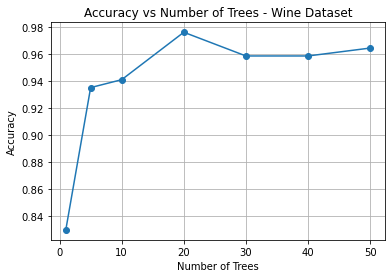

In [4]:
import matplotlib.pyplot as plt

plt.plot(n_trees_list, accuracy, marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Trees - Wine Dataset')
plt.grid(True)
plt.show()

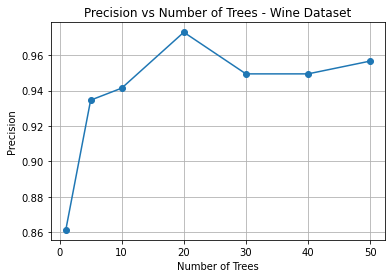

In [5]:
import matplotlib.pyplot as plt

plt.plot(n_trees_list, precision, marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('Precision')
plt.title('Precision vs Number of Trees - Wine Dataset')
plt.grid(True)
plt.show()

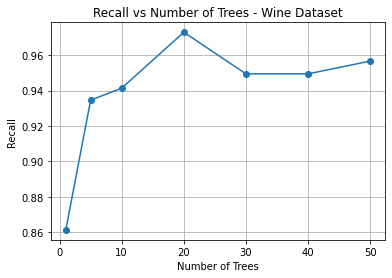

In [6]:
import matplotlib.pyplot as plt

plt.plot(n_trees_list, precision, marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('Recall')
plt.title('Recall vs Number of Trees - Wine Dataset')
plt.grid(True)
plt.show()

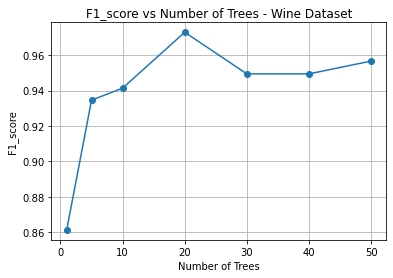

In [7]:
import matplotlib.pyplot as plt

plt.plot(n_trees_list, precision, marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('F1_score')
plt.title('F1_score vs Number of Trees - Wine Dataset')
plt.grid(True)
plt.show()